# Amazon Fine Food Reviews Analysis

## [1]. Reading Data 

### [1.1] Loading the data

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

C:\Users\BALARAMI REDDY\Anaconda3\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 


filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [6]:
display['COUNT(*)'].sum()

393063

## [2] Exploratory Data Analysis

### [2.1] Data Cleaning: Deduplication 

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

## [3] Preprocessing

### [3.1]. Preprocessing Review Tex

In [14]:
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [16]:
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [17]:
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

was way to hot for my blood, took a bite and did a jig  lol


In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

was way to hot for my blood took a bite and did a jig lol


In [21]:
stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [22]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 87773/87773 [01:10<00:00, 1238.41it/s]


In [23]:
preprocessed_reviews[1500]

'way hot blood took bite jig lol'

## [4] Featurization

### [4.3] TF-IDF

In [24]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['aa', 'aafco', 'aback', 'abandon', 'abandoned', 'abdominal', 'ability', 'able', 'able add', 'able brew']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (87773, 51709)
the number of unique words including both unigrams and bigrams  51709


## [5] Truncated SVD

### [5.1] Taking top features from TFIDF

In [26]:
# Getting words :
word = tf_idf_vect.get_feature_names()
word[200:210]

['actual tea',
 'actuality',
 'actually',
 'actually ate',
 'actually better',
 'actually bit',
 'actually bought',
 'actually buy',
 'actually came',
 'actually cheaper']

In [27]:
# Now we have to get TOP N Features :->
# Code From -> https://buhrmann.github.io/tfidf-analysis.html
def get_top_n_features(row, features, top_n): #Function takes in a row.
    # returns a dataframe with top n features :
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

In [28]:
tfidf_mean = np.mean(final_tf_idf, axis = 0)
tfidf_mean = np.array(tfidf_mean)[0].tolist()

In [29]:
top_feat = get_top_n_features(tfidf_mean, word, 2000)
top_feat.shape

(2000, 2)

In [30]:
# Displaying the top 5 features out of top 2000 features obtained.
top_feat.head()

,feature,tfidf
0,not,0.031660
1,like,0.018491
2,good,0.017401
3,great,0.017265
4,coffee,0.016710


### [5.2] Calulation of Co-occurrence matrix

In [38]:
# Accepts a dataframe with all columns and number of features to select...
# returns a Cooccurance Matrix of size n = number of features passed as an argument.
def getCooccuranceMatrix(sample_data, numfeat):
    # Get the Top Features !!!
    print("Getting top features")
    tfidf = TfidfVectorizer(max_features = numfeat)
    tf_train = tfidf.fit_transform(preprocessed_reviews)
    # Store feature names
    words = tfidf.get_feature_names()
    # Displaying top 5 features
    tfidf_mean = np.mean(tf_train, axis = 0)
    tfidf_mean = np.array(tfidf_mean)[0].tolist()
    
    top_feat = get_top_n_features(tfidf_mean, words, numfeat)
    print("Done.")
    print("Printing some features ")
    print(top_feat.head())
    print("\n********************************")
    
    print("Generating cooccurance matrix \n")
    # Generate n X n matrix and fill initially with 0.
    arr = np.array([[0 for x in range(numfeat)] for x in range(numfeat)])
    df = pd.DataFrame(arr, index=words, columns=words)
    k = 0
    total = sample_data.shape[0]
    div = total / 10
    
    # Start reading each sentence..
    for sent in preprocessed_reviews:
        #sent = sent.decode('utf-8')
        #Split the sentence into words.
        words = sent.split(" ")
        for i in range(len(words)):
            # Check in context with wordi , check 5 neighbours , if present in matrix add to the sum else ignore.
            for j in range(1,6):
                if(i + j < len(words) and words[i] != words[j]):
                    try:
                        df.loc[words[i], words[j]] += 1 # If word i occurs in the proximity of word j add +1 to matrix.
                        df.loc[words[j], words[i]] += 1 # Same as above for word j
                    except:
                        pass
        # This is for checking the progess
        if(k % div == 0 and k != 0):
            percent = float(k/total) * 100.0
            print("Percentage Completed:{}%".format(percent))
                
        k = k + 1
    print("Done!!")         
    return (df, top_feat['feature'])

In [39]:
df, top_feat_names = getCooccuranceMatrix(final, 2000)

Getting top features
Done.
Printing some features 
  feature     tfidf
0     not  0.053074
1    like  0.031178
2    good  0.029750
3   great  0.029730
4  coffee  0.028802

********************************
Generating cooccurance matrix 

Done!!


In [40]:
df.shape

(2000, 2000)

### [5.3] Finding optimal value for number of components (n) to be retained

In [43]:
# Accepts a cooccurance matrix and a list of k, to choose from
# Returns U, Sigma, VT
# Prints variance of individual components and a plot showing how many components need for most variance explained.
from sklearn.decomposition import TruncatedSVD
def SVDTruncated(matrix, k):
    # Variance will store the value of explained variance for each value of k
    variance = []
    maxexp = -1
    svdret = 0
    for comp in k:
        svd = TruncatedSVD(n_components=comp)
        svd.fit(matrix)
        expsum = svd.explained_variance_ratio_.sum() # Calculate the explained variance ratio sum.
        variance.append(expsum)
        if expsum > maxexp: # Store the svd which explained maximum variance.
            svdret = svd
            maxexp = expsum

    # Plotting for best value of K
    plt.plot(k, variance)
    plt.title("Variance Explained vs. Number of Components")
    plt.xlabel("K")
    plt.ylabel("Total Variance Explained in %")
    plt.show()
    U = svdret.transform(matrix)
    VT = svdret.components_
    
    arr = np.array([[0 for x in range(svdret.singular_values_.shape[0])] for x in range(svdret.singular_values_.shape[0])])
    for i in range(svdret.singular_values_.shape[0]):
        arr[i, i] = svdret.singular_values_[i]
        
    Sigma = arr
    return (U, Sigma, VT)

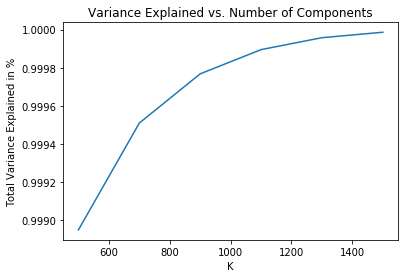

In [44]:
U, Sigma, VT = SVDTruncated(df, [500, 700, 900, 1100, 1300, 1500])

In [45]:
print(U.shape, " ", Sigma.shape, " ", VT.shape)

(2000, 1500)   (1500, 1500)   (1500, 2000)


### [5.4] Applying k-means clustering

In [46]:
# Importing k-Means class from sklearn
from sklearn.cluster import KMeans

# Number of clusters to check.
num_clus = [x for x in range(3,11)]
num_clus

[3, 4, 5, 6, 7, 8, 9, 10]

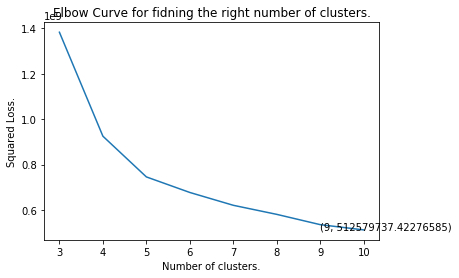

The optimal number of clusters obtained is -  9
The loss for optimal cluster is -  512579737.42276585


In [47]:
# Choosing the best cluster using Elbow Method.
squared_errors = []
for cluster in num_clus:
    kmeans = KMeans(n_clusters = cluster, n_jobs = -1).fit(U) # Training Clustering.
    squared_errors.append(kmeans.inertia_) # Appending the squared loss obtained in the list
    
optimal_clusters = np.argmin(squared_errors) + 2 # As argmin return the index of minimum loss. 
plt.plot(num_clus, squared_errors)
plt.title("Elbow Curve for fidning the right number of clusters.")
plt.xlabel("Number of clusters.")
plt.ylabel("Squared Loss.")
xy = (optimal_clusters, min(squared_errors))
plt.annotate('(%s, %s)' % xy, xy = xy, textcoords='data')
plt.show()

print ("The optimal number of clusters obtained is - ", optimal_clusters)
print ("The loss for optimal cluster is - ", min(squared_errors))

In [48]:
optimal_k = 9
# Variable that will be used in the conclusion 
bow_means_k = optimal_k

# Implementing K-Means++ using optimal value of K
kmeans = KMeans(n_clusters=optimal_k, n_jobs=-1).fit(U)

In [49]:
reviews = preprocessed_reviews
# Getting all the reviews in different clusters
cluster1 = []
cluster2 = []
cluster3 = []
cluster4 = []
cluster5 = []
cluster6 = []
cluster7 = []
cluster8 = []
cluster9 = []

for i in range(kmeans.labels_.shape[0]):
    if kmeans.labels_[i] == 0:
        cluster1.append(reviews[i])
    elif kmeans.labels_[i] == 1:
        cluster2.append(reviews[i])
    elif kmeans.labels_[i] == 2:
        cluster3.append(reviews[i])
    elif kmeans.labels_[i] == 3:
        cluster4.append(reviews[i])
    elif kmeans.labels_[i] == 4:
        cluster5.append(reviews[i])
    elif kmeans.labels_[i] == 5:
        cluster6.append(reviews[i])
    elif kmeans.labels_[i] == 6:
        cluster7.append(reviews[i])
    elif kmeans.labels_[i] == 7:
        cluster8.append(reviews[i])
    else :
        cluster9.append(reviews[i]) 
        
# Number of reviews in different clusters
print("No. of reviews in Cluster-1 : ",len(cluster1))
print("\nNo. of reviews in Cluster-2 : ",len(cluster2))
print("\nNo. of reviews in Cluster-3 : ",len(cluster3))
print("\nNo. of reviews in Cluster-4 : ",len(cluster4))
print("\nNo. of reviews in Cluster-5 : ",len(cluster5))
print("\nNo. of reviews in Cluster-6 : ",len(cluster6))
print("\nNo. of reviews in Cluster-7 : ",len(cluster7))
print("\nNo. of reviews in Cluster-8 : ",len(cluster8))
print("\nNo. of reviews in Cluster-9 : ",len(cluster9))

No. of reviews in Cluster-1 :  1463

No. of reviews in Cluster-2 :  17

No. of reviews in Cluster-3 :  135

No. of reviews in Cluster-4 :  1

No. of reviews in Cluster-5 :  2

No. of reviews in Cluster-6 :  7

No. of reviews in Cluster-7 :  318

No. of reviews in Cluster-8 :  2

No. of reviews in Cluster-9 :  55


### [5.5] Wordclouds of clusters obtained in the above section

In [51]:
#Reading reviews manually
cluster1[0]

'dogs love saw pet store tag attached regarding made china satisfied safe'

[nltk_data] Downloading package punkt to C:\Users\BALARAMI
[nltk_data]     REDDY\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
cluster1 Word-Cloud


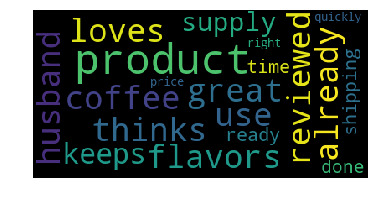

In [56]:
import nltk
nltk.download('punkt')
  

for val in cluster1:
    text = val.lower()
    tokens = nltk.word_tokenize(text)
    tokens = cluster1
    for words in tokens:
        cluster1_words = words + ' '

from wordcloud import WordCloud
plt.ion()
print ("cluster1 Word-Cloud")
wordcloud = WordCloud(max_font_size=50).generate(cluster1_words)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show() 

In [57]:
cluster2[0]

'dog loves things hes moderate chewer takes weeks go suggest throw away starts get small worry jagged edges not seem get moldy thank goodness one major drawback stepping darn thing barefoot ouch'

cluster2 Word-Cloud


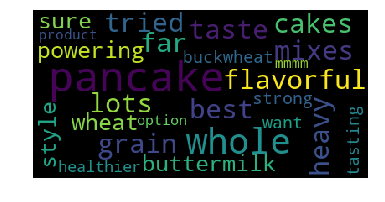

In [59]:
for val in cluster2:
    text = val.lower()
    tokens = nltk.word_tokenize(text)
    tokens = cluster2
    for words in tokens:
        cluster2_words = words + ' '

from wordcloud import WordCloud
plt.ion()
print ("cluster2 Word-Cloud")
wordcloud = WordCloud(max_font_size=50).generate(cluster2_words)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show() 

In [61]:
cluster3[0]

'infestation fruitflies literally everywhere flying around kitchen bought product hoping least get rid weeks fly stuck going around notepad squishing buggers success rate day clearly product useless even dabbed red wine banana top column week really attracted red wine glass still nothing get stuck actually saw second fly land watched flapped wings frantically within secs unstuck product total waste money'

cluster3 Word-Cloud


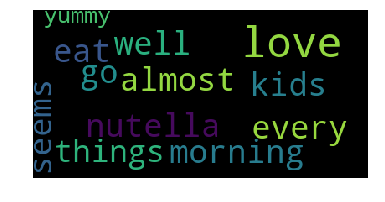

In [60]:
for val in cluster3:
    text = val.lower()
    tokens = nltk.word_tokenize(text)
    tokens = cluster3
    for words in tokens:
        cluster3_words = words + ' '

from wordcloud import WordCloud
plt.ion()
print ("cluster3 Word-Cloud")
wordcloud = WordCloud(max_font_size=50).generate(cluster3_words)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [62]:
cluster4[0]

'like get unusual strange candies often foreign nieces nephews birthdays try fun one thought sounded interesting try literally made nauseous quite time looking tiny packets salt product candy want keep looking'

cluster4 Word-Cloud


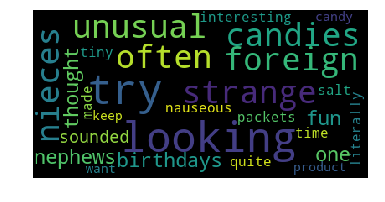

In [63]:
for val in cluster4:
    text = val.lower()
    tokens = nltk.word_tokenize(text)
    tokens = cluster4
    for words in tokens:
        cluster4_words = words + ' '

from wordcloud import WordCloud
plt.ion()
print ("cluster4 Word-Cloud")
wordcloud = WordCloud(max_font_size=50).generate(cluster4_words)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show() 

In [64]:
cluster5[0]

'always look forward home treats could picked elsewhere locations told cheaper not time arrived time scheduled enjoyed family kids looking forward making coworkers soon good stuff not wait get hands road'

cluster5 Word-Cloud


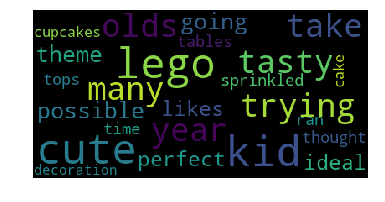

In [65]:
for val in cluster5:
    text = val.lower()
    tokens = nltk.word_tokenize(text)
    tokens = cluster5
    for words in tokens:
        cluster5_words = words + ' '


from wordcloud import WordCloud
plt.ion()
print ("cluster5 Word-Cloud")
wordcloud = WordCloud(max_font_size=50).generate(cluster5_words)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show() 

In [66]:
cluster6[0]

'not huge mustard fan comes vinegary tastes mustard brillant really perfect dipping pretzles great cheese strong great flavor'

cluster6 Word-Cloud


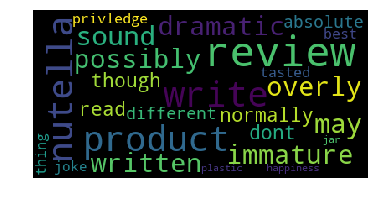

In [67]:
for val in cluster6:
    text = val.lower()
    tokens = nltk.word_tokenize(text)
    tokens = cluster6
    for words in tokens:
        cluster6_words = words + ' '


from wordcloud import WordCloud
plt.ion()
print ("cluster6 Word-Cloud")
wordcloud = WordCloud(max_font_size=50).generate(cluster6_words)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [68]:
cluster7[0]

'dogs loves chicken product china wont buying anymore hard find chicken products made usa one isnt bad good product wont take chances till know going china imports'

cluster7 Word-Cloud


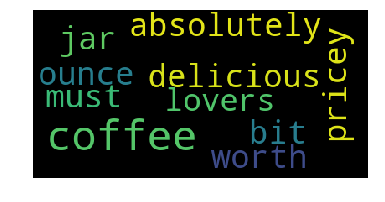

In [69]:
for val in cluster7:
    text = val.lower()
    tokens = nltk.word_tokenize(text)
    tokens = cluster7
    for words in tokens:
        cluster7_words = words + ' '


from wordcloud import WordCloud
plt.ion()
print ("cluster7 Word-Cloud")
wordcloud = WordCloud(max_font_size=50).generate(cluster7_words)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [70]:
cluster8[1]

'bought amish types place think may old not pop well microwave much better luck types popcorn would not buy'

cluster8 Word-Cloud


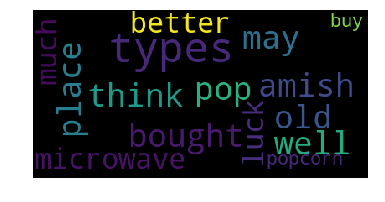

In [71]:
for val in cluster8:
    text = val.lower()
    tokens = nltk.word_tokenize(text)
    tokens = cluster8
    for words in tokens:
        cluster8_words = words + ' '


from wordcloud import WordCloud
plt.ion()
print ("cluster8 Word-Cloud")
wordcloud = WordCloud(max_font_size=50).generate(cluster8_words)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [72]:
cluster9[0]

'one favorite places frequent afford nice meal pungent moon trenton besides steaks macadamia encrusted tilapia one best things place heavenly coffee serve fine desserts coffee actually one main reasons go one night enjoying meal asked coffee dessert got served rancid stuff almost spit first sip table run bathroom gagging made back table barely asked waiter wide world sports happened coffee said filming television commercial folger secretly replacing coffee folger film people reactions coffee switch needless say not get commercial would not savvy marketing folger show guy gagging making beeline bathroom tasting coffee not know got people commercials rave coffee not anyone restaurant people not reaction lot making faces like would smelled dead octopus dirty trick would think folger would bagged idea commercial seeing people reactions guess found schmo say liked someone wanting tv go figure'

cluster9 Word-Cloud


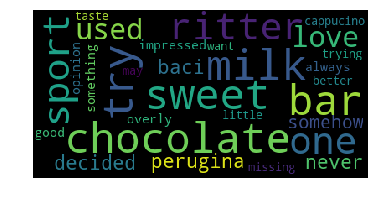

In [73]:
for val in cluster9:
    text = val.lower()
    tokens = nltk.word_tokenize(text)
    tokens = cluster9
    for words in tokens:
        cluster9_words = words + ' '


from wordcloud import WordCloud
plt.ion()
print ("cluster9 Word-Cloud")
wordcloud = WordCloud(max_font_size=50).generate(cluster9_words)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

### Conclusion:

1. We performed clustering and grouped them

2.We can see that some clusters have only one or two reviews and some have many more reviewss.